# Machine Learning and Statistics for Physicists

**This notebook is still in development.**

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

We have already encountered algorithms based on expectation-maximization (EM) for clustering (KMeans) and density estimation (GMM).  In this notebook, we develop the general theory of EM, which builds on some ideas from [optimization](Optimization.ipynb) and [variational inference](Variational.ipynb).

## Maximum-Likelihood Optimization

Suppose we can write down a joint likelihood $P(X,Y\mid \Theta)$ but only observe $Y$, with the marginal likelihood
$$
P(Y\mid \Theta) = \int P(X, Y\mid\Theta)\, dX \; .
$$
The **Expectation-Maximization** method solves the maximum-likelihood optimization problem
$$
\Theta_{ML} = \underset{\Theta}{\mathrm{argmin}}\,\left[ -\log P(Y\mid\Theta) \right]
$$
with an alternating sequence of E-steps and M-steps.

The key idea is to use an upper bound for the marginal negative-log-likelihood by introducing an arbitrary distribution $Q(X)$ over the unobserved $X$:
$$
\begin{aligned}
-\log P(Y\mid \Theta) &= -\log \int Q(X)\, \frac{P(X, Y\mid\Theta)}{Q(X)}\, dX \\
&\le -\int Q(X) \log \frac{P(X, Y\mid\Theta)}{Q(X)} \, dX
\end{aligned}
$$
where we apply Jensen's inequality to the concave function $f(z) = -\log z$ to obtain the upper bound.

This result holds for any $Q(X)$, but is most useful when the upper bound is "tight". Given observed $Y$, we can construct $Q(X)$ to achieve equality at $\Theta=\Theta_0$ using:
$$
Q(X) = P(X\mid Y,\Theta_0) = \frac{P(X, Y\mid\Theta_0)}{P(Y\mid\Theta_0)} \; .
$$
The calculation of this $Q(X)$ given the observed $Y$ and assumed $\Theta_0$ is the **E-step**: it uses the current $\Theta_0$ to estimate the distribution of the unobserved $X$.

The **M-step** consists of optimizing the upper bound with respect to $\Theta$ using the $Q(x)$ obtained from the the most recent E-step. The result is our new $\Theta_0$:
$$
\Theta_0 \leftarrow \underset{\Theta}{\mathrm{argmin}}\, \left[
-\int Q(X) \log \frac{P(X, Y\mid\Theta)}{Q(X)} \, dX \right]
$$

Plugging the $Q(x)$ above into the lower bound, we find:
$$
\begin{aligned}
-\log P(Y\mid \Theta) &\le
-\int Q(X) \log \frac{P(X, Y\mid\Theta)}{Q(X)} \, dX \\
&= -\int \frac{P(X,Y\mid\Theta_0)}{P(Y\mid\Theta_0)} \log\left[
\frac{P(X,Y\mid\Theta)}{P(X,Y\mid\Theta_0)}\, P(Y\mid\Theta_0)\right]\,dX \\
&= -\frac{1}{P(Y\mid\Theta_0)} \int P(X,Y\mid\Theta_0) \left[
\log \frac{P(X,Y\mid\Theta)}{P(X,Y\mid\Theta_0)} + \log P(Y\mid\Theta_0)\right]\,dX \\
&= -\log P(Y\mid\Theta_0) - \frac{1}{P(Y\mid\Theta_0)}
\int P(X,Y\mid\Theta_0) \log \frac{P(X,Y\mid\Theta)}{P(X,Y\mid\Theta_0)}\,dX \\
\end{aligned}
$$

Since $P(Y\mid\Theta_0)$ is a positive constant, minimizing this lower bound is equivalent to minimizing the simpler quantity
$$
-\int P(X, Y\mid\Theta_0) \log \frac{P(X, Y\mid\Theta)}{P(X, Y\mid\Theta_0)}\, dX
= \text{KL}\left[P(X, Y\mid\Theta_0) \parallel P(X, Y\mid\Theta) \right] \; ,
$$
which we recognize as the KL divergence between the joint probabilities with $\Theta$ fixed or floating.

### E-M Example

For example, suppose $(X,Y)$ are points along a line passing through the origin described by a slope parameter $\Theta$, with homescedastic errors $\sigma_y$ in $y$, and $|x| \le L$.

In [27]:
def generate(n=100, theta=2.5, L=1.5, sigma_y=0.2, seed=123):
    gen = np.random.RandomState(seed=seed)
    X = gen.uniform(-L, +L, n)
    Y = theta * X + sigma_y * gen.normal(size=n)
    return X, Y
    
X, Y = generate()

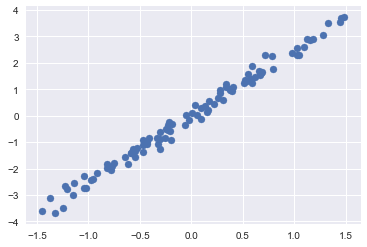

In [28]:
plt.scatter(X, Y)

The joint likelihood of a single sample $(x, y)$ is:
$$
P(X, Y\mid\Theta) = \frac{1}{\sqrt{2\pi}\sigma_y} \exp\left[
-\frac{(\theta x - y)^2}{2 \sigma_y^2}\right]
$$

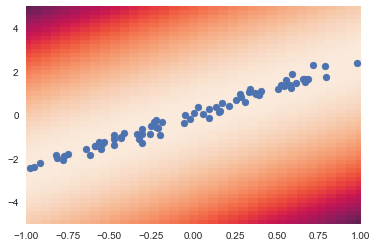

In [29]:
def plot_joint(theta=2.5, L=1.5, sigma_y=0.2, ylim=5):
    x = np.linspace(-L, +L, 51)
    y = np.linspace(-ylim, +ylim, 51).reshape(-1, 1)
    logL = -0.5 * sigma_y ** -2 * (theta * x - y) ** 2
    plt.imshow(logL, interpolation='none', extent=(x[0], x[-1], y[0], y[-1]),
               aspect='auto', origin='lower')
    plt.scatter(X, Y)
    plt.xlim(-1, 1)
    plt.grid(False)
    
plot_joint()

with a marginal likelihood:
$$
P(Y\mid\Theta) = \frac{1}{2 c_1} \left[
\text{erf}\left(\frac{\theta L - y}{\sqrt{2}\sigma_y}\right) +
\text{erf}\left(\frac{\theta L + y}{\sqrt{2}\sigma_y}\right)
\right]
$$

The EM method uses a lower bound for the marginal likelihood by introducing an arbitrary distribution $Q(X)$ over the unobserved $X$:
$$
\begin{aligned}
\log P(Y\mid \Theta) &= \log \int Q(X)\, \frac{P(X, Y\mid\Theta)}{Q(X)}\, dX \\
&\ge \int Q(X) \log \frac{P(X, Y\mid\Theta)}{Q(X)} \, dX
\end{aligned}
$$
where we apply Jensen's inequality to the convex log function to obtain the lower bound.

In [22]:
from scipy.special import erf

In [34]:
def log_marginal(theta, y, L=1.5, sigma_y=0.2):
    denom = np.sqrt(2) * sigma_y
    return np.log(0.5 / theta * (erf((theta * L - y) / denom) + erf((theta * L + y) / denom)))

In [48]:
def log_bound(theta, y, Q, L=1.5, sigma_y=0.2):
    x = np.linspace(-L, +L, 201).reshape(-1, 1)
    Qx = Q(x)
    print(x.shape, Qx.shape)
    Qx /= np.trapz(Qx, x, axis=0)
    logPxy = -0.5 * (theta * x - y) ** 2 / sigma_y ** 2 - 0.5 * np.log(2 * np.pi * sigma_y ** 2)
    integrand = Qx * (logPxy - np.log(Qx))
    return np.trapz(integrand, x, axis=0)

(201, 1) (201, 1)
(201, 1) (201, 1)


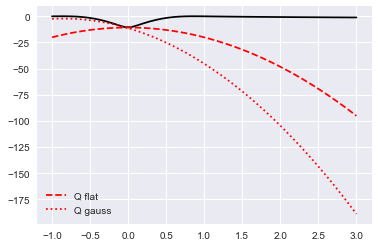

In [52]:
def plot_Estep(y=1):
    theta = np.linspace(-1, 3, 51)
    m = log_marginal(theta, y)
    plt.plot(theta, m, 'k-')
    Q = lambda x: 1 + 0. * x
    b = log_bound(theta, y, Q)
    plt.plot(theta, b, 'r--', label='Q flat')
    Q = lambda x: -(x - 1) ** 2
    b = log_bound(theta, y, Q)
    plt.plot(theta, b, 'r:', label='Q gauss')
    plt.legend()
    
plot_Estep()